# 🎯 1. Introduction

1.1. Outline

X company manufactures orthopedic devices and sells them worldwide. The company sells directly to individual doctors who use them on rehabilitation and physical therapy patients. Historically, the sales and customer support departments have grouped doctors by geography. However, the region is not a good predictor of the number of purchases a doctor will make or their support needs. We want to use a data-centric approach to segmenting doctors to improve marketing, customer service, and product planning. Our main goal throughout this analysis is composed of three objectives:

- The number of doctors and their average number of purchases per region

- The relationship between purchases and complaints

- New customer segmentation

1.2 The data

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

Doctors contains information on doctors. Each row represents one doctor.

- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate" and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

**Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.**
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

**Complaints collects information on doctor complaints.**
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

**Instructions has information on whether the doctor includes special instructions on their orders.**
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.


# 🧩 2. Analysis

In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

try:
    from yellowbrick.cluster.elbow import kelbow_visualizer
except ModuleNotFoundError:
    ! pip install yellowbrick
    from yellowbrick.cluster.elbow import kelbow_visualizer
    
try:
    from kmeans_interp.kmeans_feature_imp import KMeansInterp
except ModuleNotFoundError:
    ! git clone https://github.com/YousefGh/kmeans-feature-importance.git
    ! mv "./kmeans-feature-importance/kmeans_interp/" "."
    ! pip install -r "kmeans-feature-importance/requirements.txt"
    from kmeans_interp.kmeans_feature_imp import KMeansInterp 


# Set style
plt.style.use('fivethirtyeight')

👩‍⚕️importing ``doctor`` dataset

In [2]:
#Importing the doctor data
doctors = pd.read_csv('doctors.csv')
doctors.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0


💸importing ``orders`` dataset

In [3]:
orders = pd.read_csv('orders.csv')
orders.head()

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN


⭕️ importing ``complaint`` dataset

In [4]:
complaints = pd.read_csv('complaints.csv')
complaints.head()

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


📖 importing ``instructions`` dataset

In [5]:
instructions = pd.read_csv('instructions.csv')
instructions.head()

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes


# **Objective 1: Analysing number of doctors in each region and finding average number of purchases per region.**

C:\Users\msquy\AppData\Local\Temp/ipykernel_21640/4267539399.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(count_doc_reg.index, rotation=90)
C:\Users\msquy\AppData\Local\Temp/ipykernel_21640/4267539399.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(avg_pur_reg.index, rotation=90)


Text(0, 0.5, 'Average purchase')

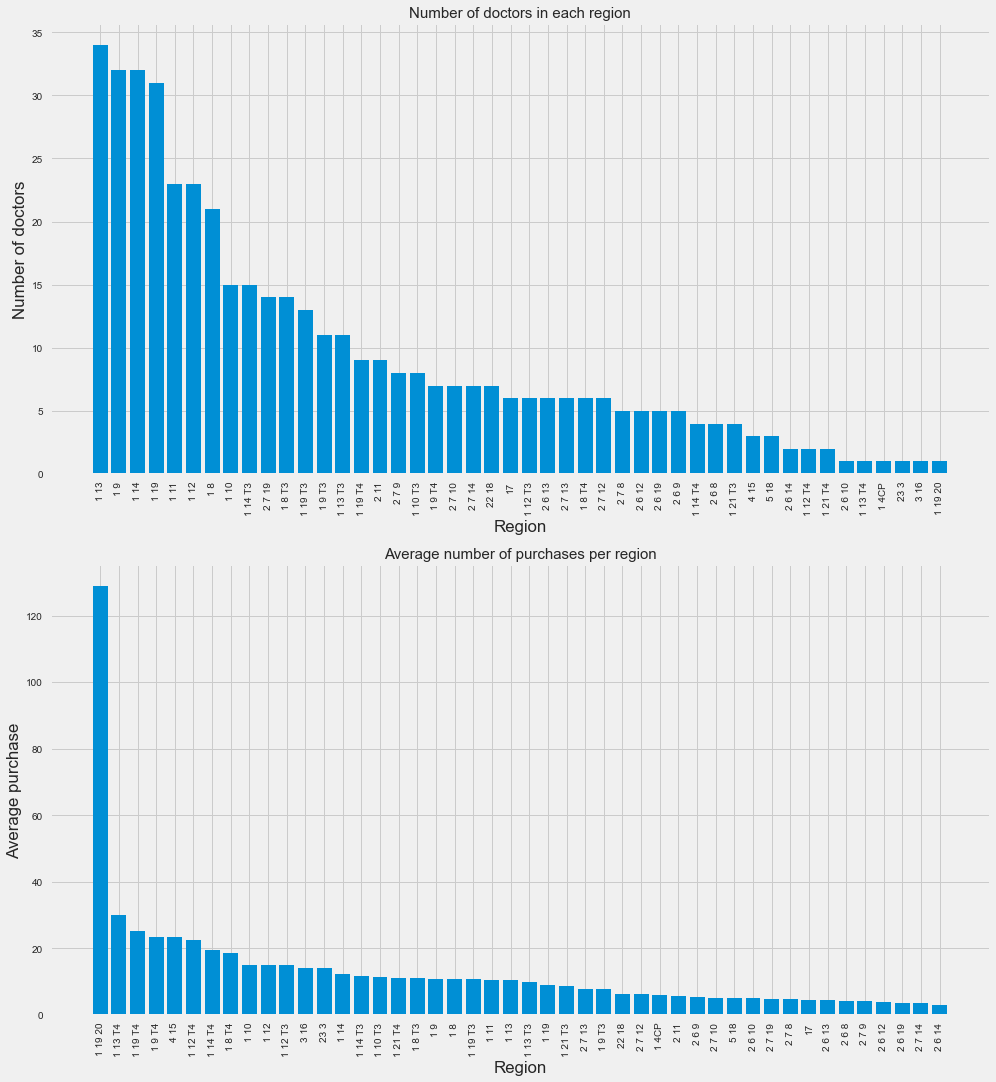

In [6]:
#number of doctors in each region
count_doc_reg= doctors.groupby('Region')['DoctorID'].count()
count_doc_reg = count_doc_reg.sort_values(ascending=False)

#average number of purchases per region
avg_pur_reg = doctors.groupby('Region')['Purchases'].mean()
avg_pur_reg = avg_pur_reg.sort_values(ascending=False)


# Visualising data
fig, axes = plt.subplots(2, 1, figsize = (15,17))
axes[0].set_title('Number of doctors in each region', size = 15)
axes[0].bar(count_doc_reg.index, count_doc_reg.values)
axes[0].set_xlabel('Region')
axes[0].set_xticklabels(count_doc_reg.index, rotation=90)
axes[0].set_ylabel('Number of doctors')

axes[1].set_title('Average number of purchases per region', size = 15)
axes[1].bar(avg_pur_reg.index, avg_pur_reg.values)
axes[1].set_xlabel('Region')
axes[1].set_xticklabels(avg_pur_reg.index, rotation=90)
axes[1].set_ylabel('Average purchase')

The graphs above demonstrate the number of doctors in each region and average number of purchases for each region, respectively.

One prominent exception is the region 1 19 20. With only one customer, it has by far the highest mean number of purchases per region (this single doctor purchased the highest ammount of our devices - 129), but still it doesn't show impressive value on the total ammont of purchases per each region (Fig 3).

Additionally, we can observe a drastic decrease of purchases in the second half of the regions. Both the number of doctors as well as the mean & total ammounts of purchases are remarkably small there, compared to the other regions. We can speculate, that our company has newly appeared in those regions and a lot of marketing effords are yet to be done. This is an important point in order to plan our nearest marketing strategy.

**Findings**

i) '1 13', '1 9' and '1 14' are the top 3 regions with the concerned doctor population.

ii) Region '1 19 20' has the highest average purchase of medical devices, compared to the other regions.

iii) It should be noted here that the region '1 19 20', which witnessed the highest average purchase, is also the region with the least number of doctors. This brings the characteristics of region '1 19 20' and its doctors under spotlight, as the region has a comparatively high average purchase per doctor!!

# Data Pre-processing

This will invlove merging important fields from different datasets and preliminary cleaning of the data, to prepare it for further analysis.

In [7]:
#merging doctors dataset to orders dataset
data_1 = doctors.merge(orders, how='outer', on ='DoctorID')

#merging data_1 to complaints dataset
data_2 = data_1.merge(complaints, how='outer', on = 'DoctorID')

#Merging data_2 to instructions dataset
data_combined = data_2.merge(instructions, how = 'outer', on = 'DoctorID')

#Checking final combined dataset's summary stats:
print('Total number of unique doctors: ',len(data_combined['DoctorID'].unique()))
print('Total number of columns in the combined dataset: ', data_combined.shape[1])

#Checking datatypes
data_combined.dtypes

Total number of unique doctors:  647
Total number of columns in the combined dataset:  23


DoctorID           object
Region             object
Category           object
Rank               object
Incidence rate    float64
R rate            float64
Satisfaction       object
Experience        float64
Purchases         float64
OrderID            object
OrderNum           object
Condition A        object
Condition B        object
Condition C        object
Condition D        object
Condition F        object
Condition G        object
Condition H        object
Condition I        object
Condition J        object
Complaint Type     object
Qty               float64
Instructions       object
dtype: object

In [8]:
#eyeballing the missing/invalid values in the objectionale datatype fields e.g. 'Satisfaction'
data_combined['Satisfaction'].unique()

array(['53.85', '100.00', '--', '76.79', '-50.00', '14.29', '66.67',
       '37.50', '50.00', '14.71', '75.00', '-16.67', '46.67', '81.82',
       '10.00', '-31.58', '71.05', '61.54', '-100.00', '-41.18', '60.00',
       '31.58', '0.00', '94.12', '25.00', '-25.00', '3.45', '12.50',
       '23.81', '68.75', '17.65', '55.10', '-13.33', '40.00', '56.25',
       '28.57', '5.26', '36.36', '-83.33', '55.17', '83.33', '71.43',
       '58.33', '-17.39', '-66.67', '97.73', '-12.50', '93.55', '-6.67',
       '-75.00', '-20.00', '89.47', '-33.33', '7.14', '-29.41', '33.33',
       '94.44', '-5.88', '30.77', '90.48', '-90.91', '37.04', '69.57',
       '11.11', '38.46', '90.91', '62.07', '-53.85', '86.21', '-11.76',
       '65.00', '10.71', '44.44', '41.67', '87.50', '65.22', '88.89',
       '41.18', '43.75', '27.27', '-6.25', '74.47', '11.76', '23.08',
       '80.00', '90.00', '48.57', '70.00', '-29.17', '20.00', '5.88',
       '85.96', '-26.32', '64.71', '42.86', '87.10', '31.82', '-22.22',
     

In [9]:
#replacing inconsistencies in the 'Satisfaction' field and setting data type as float64
data_combined['Satisfaction'] = data_combined['Satisfaction'].replace('--', 0).astype('float64')

In [10]:
#checking missing values in the combined dataset.
percentage_missing = (data_combined.isnull().sum()/len(data_combined)*100).round().astype(int)

#dropping columns having >= 60% missing values
dropped_fields = (percentage_missing[percentage_missing.values >= 60]).index
working_dataset = data_combined.drop(dropped_fields, axis =1, inplace=False)
working_dataset.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,Complaint Type,Qty
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0,NaN,NaN
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0,NaN,NaN
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,0.00,34.0,NaN,NaN
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,0.00,0.48,29.0,NaN,NaN
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0,NaN,NaN


In [11]:
#check duplicate rows
working_dataset[working_dataset.duplicated()]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,Complaint Type,Qty
15,IFDIB,1 19 T3,Specialist,Titanium,13.0,1.29,37.5,0.14,14.0,Correct,1.0
16,IFDIB,1 19 T3,Specialist,Titanium,13.0,1.29,37.5,0.14,14.0,Correct,1.0
17,IFDIB,1 19 T3,Specialist,Titanium,13.0,1.29,37.5,0.14,14.0,Correct,1.0
18,IFDIB,1 19 T3,Specialist,Titanium,13.0,1.29,37.5,0.14,14.0,Correct,1.0
23,FDHGC,1 14,Specialist,Titanium,12.0,0.85,0.0,0.62,13.0,Correct,4.0
...,...,...,...,...,...,...,...,...,...,...,...
791,FJGEJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Correct,1.0
793,FJFEG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,1.0
794,FJFEG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,1.0
795,FJFEG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,1.0


In [12]:
#fill remaining columns' missing values with imputed values
skl_imputed = IterativeImputer()
dataset_cleaned=working_dataset.copy()
dataset_cleaned[['Incidence rate', 'R rate', 'Satisfaction', 'Experience', 'Purchases', 'Qty']]=skl_imputed.fit_transform(dataset_cleaned[['Incidence rate', 'R rate', 'Satisfaction', 'Experience', 'Purchases', 'Qty']])

dataset_cleaned.head()


,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,Complaint Type,Qty
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0,NaN,17.516763
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0,NaN,13.140995
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,0.00,34.0,NaN,12.029224
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,0.00,0.48,29.0,NaN,10.247557
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0,NaN,8.214292


In [13]:
#drop duplicate rows
print('Total rows in cleaned dataset before deduplication:', len(dataset_cleaned))
dataset_cleaned_deduped=dataset_cleaned.drop_duplicates()
print('Total rows in cleaned dataset before deduplication:', len(dataset_cleaned_deduped))


Total rows in cleaned dataset before deduplication: 1105
Total rows in cleaned dataset before deduplication: 798


# Objective 2: Finding a relationship between purchases and number of complaints.

Is There a Relation Between Complaints and Purchases?
We now have to find whether there is a relation between the number of purchases and the complaints regarding both the complaints quantity and type

As before, we do this using two approaches, one approach is using the orders data and the other using the doctors data
But... we won't stop just at the number of purchases, we might as well include all the types of the complaints in our relations

### Approach using the Orders data

We start by grouping the complaints according to each doctor and summing the total number of complaints under the Qty column
The next step is to view what types of complaints each doctor usually makes, creating a column for each complaint type

In [14]:
complaints_grouped = complaints.groupby(by=["DoctorID"],as_index=False,sort=True).Qty.sum()
complaints_grouped = pd.get_dummies(complaints, columns=["Complaint Type"]).groupby(by=["DoctorID"],as_index=False,sort=True).sum()
complaints_grouped.head()

,DoctorID,Qty,Complaint Type_Correct,Complaint Type_Incorrect,Complaint Type_R&R,Complaint Type_Specific,Complaint Type_Unknown
0,AAAEAH,1,1,0,0,0,0
1,AAAHCE,4,1,1,0,0,1
2,AABDHC,1,0,1,0,0,0
3,AABGAB,4,1,0,0,0,1
4,AACCGA,1,0,1,0,0,0


Then we group the orders data according to each doctor and summing the total number of orders under the Count column

In [15]:
orders_cleaned = orders.dropna()
orders_df=pd.DataFrame(orders_cleaned['DoctorID'].value_counts()).reset_index()
orders_df.columns=['DoctorID','Count']
orders_df=pd.merge(orders_df, doctors.iloc[:,:2], on='DoctorID', how='left')

orders_grouped = orders_df.groupby('Region').mean().reset_index()
orders_grouped['Count'] = round(orders_grouped["Count"], 2)

orders_grouped = orders_df.groupby('DoctorID').sum()
doctors_IDS=doctors['DoctorID']
orders_grouped = pd.merge(doctors_IDS, orders_grouped, on='DoctorID', how='left').fillna(0).sort_values('Count', ascending=False)
orders_grouped.head()

,DoctorID,Count
116,AAAEAH,10.0
398,FAHDI,9.0
273,FBFHB,8.0
146,AFCADC,6.0
179,FAGIE,5.0


Then we merge the two dataframes together to use it as our correlation data

In [16]:
orders_complaints = pd.merge(orders_grouped, complaints_grouped, on='DoctorID', how='left').fillna(0)
orders_complaints.rename(columns={'Count': 'Number of orders', 'Qty': 'Number of complaints'}, inplace=True)
orders_complaints.head()

,DoctorID,Number of orders,Number of complaints,Complaint Type_Correct,Complaint Type_Incorrect,Complaint Type_R&R,Complaint Type_Specific,Complaint Type_Unknown
0,AAAEAH,10.0,1.0,1.0,0.0,0.0,0.0,0.0
1,FAHDI,9.0,2.0,1.0,1.0,0.0,0.0,0.0
2,FBFHB,8.0,2.0,1.0,1.0,0.0,0.0,0.0
3,AFCADC,6.0,2.0,1.0,1.0,0.0,0.0,0.0
4,FAGIE,5.0,4.0,1.0,1.0,0.0,0.0,0.0


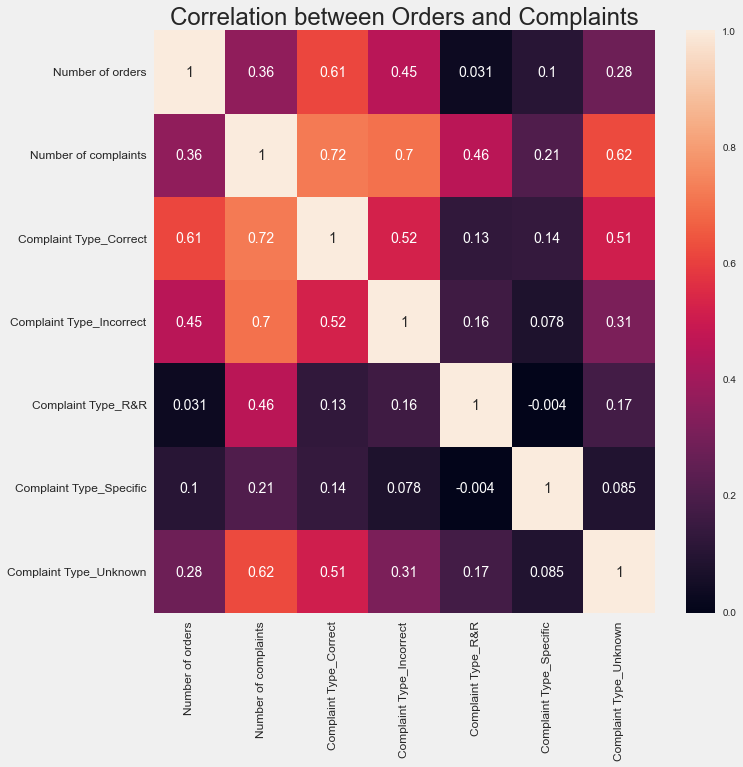

In [17]:
plt.figure(figsize = (10,10))

ax = sns.heatmap(orders_complaints.corr(), annot=True)
ax.set_title("Correlation between Orders and Complaints",  fontsize=24)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_xticklabels(ax.get_xticklabels(), size = 12)
plt.show()

### Approach using the doctors data

We start by merging the complaints data previously created with the total number of purchases from the doctors data

In [18]:
doctors_grouped = doctors[['DoctorID','Purchases']]

purchases_complaints = pd.merge(doctors_grouped, complaints_grouped, on="DoctorID", how="left").fillna(0)
purchases_complaints.rename(columns = {'Count':'Number of orders', 'Qty':'Number of complaints'}, inplace = True)
purchases_complaints = purchases_complaints.sort_values('Number of complaints', ascending=False)
purchases_complaints.head()

,DoctorID,Purchases,Number of complaints,Complaint Type_Correct,Complaint Type_Incorrect,Complaint Type_R&R,Complaint Type_Specific,Complaint Type_Unknown
165,AAEIEG,11.0,20.0,1.0,1.0,1.0,0.0,1.0
109,BABEFH,7.0,14.0,1.0,1.0,0.0,0.0,1.0
392,FBHHI,11.0,12.0,1.0,1.0,0.0,0.0,1.0
358,AIEBFD,8.0,12.0,1.0,1.0,0.0,1.0,1.0
25,AEFEAG,10.0,10.0,1.0,1.0,0.0,0.0,0.0


Then we plot the relation between the number of purchases and the complaints number and types

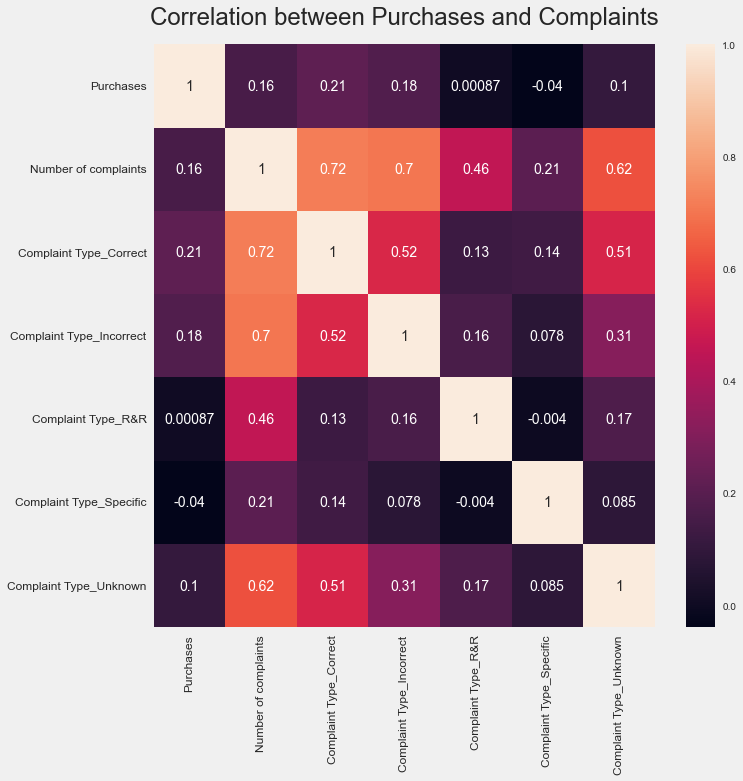

In [19]:
plt.figure(figsize = (10,10))

ax = sns.heatmap(purchases_complaints.corr(), annot=True)
ax.set_title("Correlation between Purchases and Complaints",  fontsize=24, pad=20)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_xticklabels(ax.get_xticklabels(), size = 12)
plt.show()

# Objective 3: Defining new doctor segments to help the company improve marketing efforts and customer service.

In [20]:
doc_prepared = doctors.copy()
doc_prepared['Satisfaction'] = np.where(doc_prepared['Satisfaction'] == '--', 0, doc_prepared['Satisfaction'])

doc_prepared['Region'] = doc_prepared['Region'].astype('category')
doc_prepared['Category'] = doc_prepared['Category'].astype('category')
doc_prepared['Rank'] = doc_prepared['Rank'].astype('category')

Region_dict = dict(enumerate(doc_prepared['Region'].cat.categories))
Category_dict = dict(enumerate(doc_prepared['Category'].cat.categories))
Rank_dict = dict(enumerate(doc_prepared['Rank'].cat.categories))

doc_prepared['Region'] = doc_prepared['Region'].cat.codes
doc_prepared['Category'] = doc_prepared['Category'].cat.codes
doc_prepared['Rank'] = doc_prepared['Rank'].cat.codes

doc_prepared.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,44,1,0,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,21,0,0,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,24,1,0,33.0,1.53,0,0.00,34.0
3,BJJHCA,1,1,0,28.0,2.03,0,0.48,29.0
4,FJBEA,11,1,0,23.0,0.96,76.79,0.75,24.0


In [21]:
#encode the instruction data
instruction_prepared = instructions.copy()
instruction_prepared['Instructions'] = np.where(instruction_prepared['Instructions'] == 'Yes', 2, 1)
instruction_prepared.head()

,DoctorID,Instructions
0,ADIFBD,2
1,ABHBED,1
2,FJFEG,2
3,AEBDAB,1
4,AJCBFE,2


Thirdly, we organize the complaints by calculating the total number of complaints per doctor and what was the most complaints type
<br>And of course we encode the most complaint type

In [22]:
sum_complaints = complaints.groupby('DoctorID', as_index=False).Qty.sum()
most_complaints = complaints.groupby('DoctorID', as_index=False).Qty.max()
most_complaints_type = complaints.groupby(['DoctorID', 'Complaint Type'], as_index=False).Qty.sum()
most_complaints = pd.merge(most_complaints, most_complaints_type, on=['DoctorID', 'Qty'])
most_complaints = most_complaints.drop_duplicates(subset='DoctorID').drop('Qty', axis=1)
complaints_prepared = pd.merge(sum_complaints, most_complaints, how='left', on='DoctorID')

complaints_prepared['Complaint Type'] = complaints_prepared['Complaint Type'].astype('category')
Complaint_dict = dict(enumerate(complaints_prepared['Complaint Type'].cat.categories))

complaints_prepared['Complaint Type'] = complaints_prepared['Complaint Type'].cat.codes.apply(lambda x: x+1)
complaints_prepared.head()

,DoctorID,Qty,Complaint Type
0,AAAEAH,1,1
1,AAAHCE,4,2
2,AABDHC,1,2
3,AABGAB,4,1
4,AACCGA,1,2


In [23]:
complaints_prepared.rename(columns = {'Complaint Type':'Most Complaint', 'Qty':'Total Complaints'}, inplace = True)
complaints_prepared.head()

,DoctorID,Total Complaints,Most Complaint
0,AAAEAH,1,1
1,AAAHCE,4,2
2,AABDHC,1,2
3,AABGAB,4,1
4,AACCGA,1,2


We then have to merge all these frames together to form one big frame to feed it to our model

In [24]:
doc_ins=pd.merge(doc_prepared, instruction_prepared, on='DoctorID', how='left').fillna(0)

doc_ins_com = pd.merge(doc_ins, complaints_prepared, on='DoctorID', how='left').fillna(0)
doc_ins_com.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,Instructions,Total Complaints,Most Complaint
0,AHDCBA,44,1,0,49.0,0.90,53.85,1.20,49.0,2.0,0.0,0.0
1,ABHAHF,21,0,0,37.0,0.00,100.00,0.00,38.0,0.0,0.0,0.0
2,FDHFJ,24,1,0,33.0,1.53,0,0.00,34.0,0.0,0.0,0.0
3,BJJHCA,1,1,0,28.0,2.03,0,0.48,29.0,0.0,0.0,0.0
4,FJBEA,11,1,0,23.0,0.96,76.79,0.75,24.0,0.0,0.0,0.0


In [25]:
doc_ins_com=doc_ins_com[doc_ins_com['Rank'] >= 0]

The last step on our frame is to scale all the columns to a range from 0 to 1 so we make sure our clustering model does not favor any column over the other.

Of course each column is scaled independently of the other columns to assure no interference

In [26]:
scaler = preprocessing.MinMaxScaler()
cluster_data = doc_ins_com.set_index('DoctorID')

normalized = scaler.fit_transform(cluster_data.values)
cluster_data = pd.DataFrame(normalized, index=cluster_data.index, columns=cluster_data.columns)
cluster_data['Rank'].value_counts()

0.000    115
0.375     77
0.875     69
0.500     54
0.250     50
0.750     44
0.125     22
0.625      3
1.000      1
Name: Rank, dtype: int64

### Creating our Clustering Model

Firstly we should know what is the optimal number of clusters to use in our model
<br>That's why we use the K elbow visualizer using three different metrics so we assure best results

C:\Users\msquy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\msquy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\msquy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\msquy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

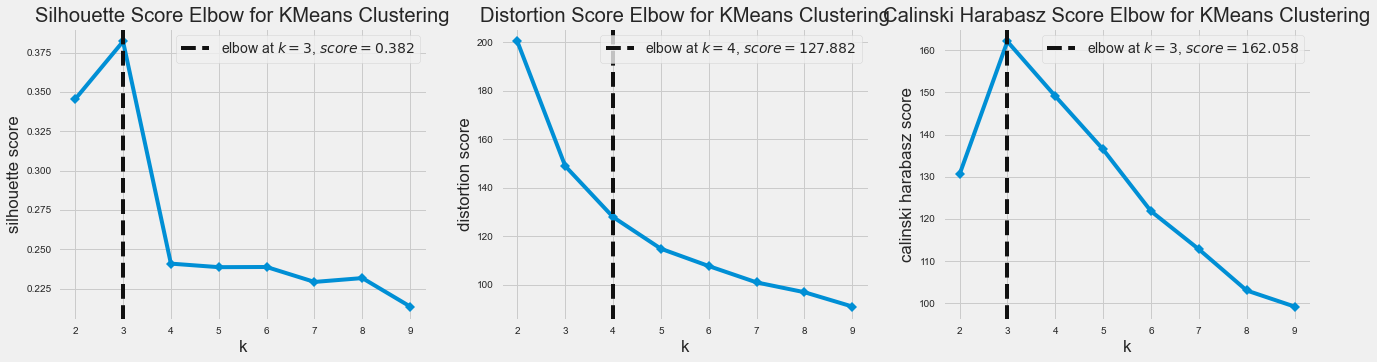

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize = (20,5))
ax1 = kelbow_visualizer(KMeans(random_state=1), X=cluster_data, k=(2, 10), metric='silhouette', timings=False, show=False, ax=ax1)
ax2 = kelbow_visualizer(KMeans(random_state=1), X=cluster_data, k=(2, 10), metric='distortion', timings=False, show=False, ax=ax2)
ax3 = kelbow_visualizer(KMeans(random_state=1), X=cluster_data, k=(2, 10), metric='calinski_harabasz', timings=False, show=False, ax=ax3)

As seen from the plots, 2 out of 3 metrics indicate that using three clusters was our best choice so we proceed with that number

Now we start creating our clustering model
We use YousefGH KMeans clustering library to create our model with a number of clusters of 3
Then we visualize the number of doctors per cluster and display some of the resulted dataframe

C:\Users\msquy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


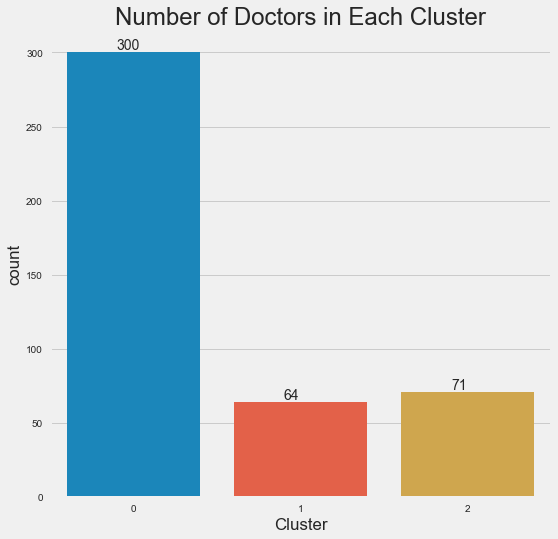

,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,Instructions,Total Complaints,Most Complaint,Cluster
DoctorID,,,,,,,,,,,,
AHDCBA,0.977778,1.0,0.0,1.000000,0.211765,0.76925,0.221402,0.365079,1.0,0.0,0.0,2
ABHAHF,0.466667,0.0,0.0,0.744409,0.000000,1.00000,0.000000,0.277778,0.0,0.0,0.0,1
FDHFJ,0.533333,1.0,0.0,0.659212,0.360000,0.50000,0.000000,0.246032,0.0,0.0,0.0,0
BJJHCA,0.022222,1.0,0.0,0.552716,0.477647,0.50000,0.088561,0.206349,0.0,0.0,0.0,0
FJBEA,0.244444,1.0,0.0,0.446219,0.225882,0.88395,0.138376,0.166667,0.0,0.0,0.0,0


In [28]:
kmeans =  KMeansInterp(n_clusters=3, random_state=0, ordered_feature_names=cluster_data.columns , feature_importance_method='wcss_min')
cluster_data['Cluster'] =  kmeans.fit_predict(cluster_data)
plt.figure(figsize = (8,8))

ax = sns.countplot(data=cluster_data, x='Cluster')
for p in ax.patches:
    ax.annotate(p.get_height() , (p.get_x()+0.3, p.get_height()+2), fontsize=14)
ax.set_title("Number of Doctors in Each Cluster", fontsize=24)

plt.show()

display(cluster_data.head())

## Which Features Impact Each Cluster the Most?

Now we need to find which feature impact our clusters the most
<br>And thanks to YousefGH Kmeans Feature Importance addition to SKLearn's clustering library, we can find the weight of each feature in each cluster
<br>After using proper calculations, we now display the feature importance of each cluster on a circular bar plot

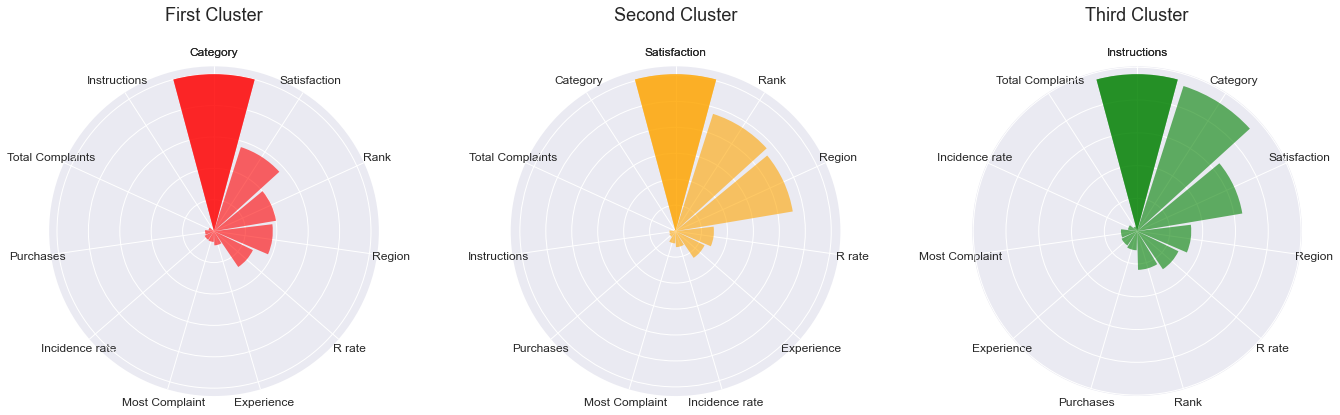

In [29]:
x = list(kmeans.feature_importances_.items())
cluster0_df = pd.DataFrame(x[0][1], columns=['Feature', 'Importance'])
cluster0_df['Importance'] = (cluster0_df['Importance']*100).round(3)
cluster0_df = cluster0_df.append(cluster0_df.iloc[0])

cluster1_df = pd.DataFrame(x[1][1], columns=['Feature', 'Importance'])
cluster1_df['Importance'] = (cluster1_df['Importance']*100).round(3)
cluster1_df = cluster1_df.append(cluster1_df.iloc[0])

cluster2_df = pd.DataFrame(x[2][1], columns=['Feature', 'Importance'])
cluster2_df['Importance'] = (cluster2_df['Importance']*100).round(3)
cluster2_df = cluster2_df.append(cluster2_df.iloc[0])

angles = np.linspace(0,2*np.pi,11, endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

plt.style.use('seaborn')
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize = (20,11), subplot_kw={'projection': 'polar'})
width = 2*np.pi / len(cluster0_df.index)

ax1.set_thetagrids(angles * 180/np.pi, cluster0_df['Feature'], size=12)
ax1.bar(angles, cluster0_df['Importance'], color='red', width=width, alpha=0.6)
ax1.set_title("First Cluster\n", size=18)
ax1.set_yticklabels([])
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)

ax2.set_thetagrids(angles * 180/np.pi, cluster1_df['Feature'], size=12)
ax2.bar(angles, cluster1_df['Importance'], color='orange', width= width, alpha=0.6)
ax2.set_title("Second Cluster\n", size=18)
ax2.set_yticklabels([])
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)

ax3.set_thetagrids(angles * 180/np.pi , cluster2_df['Feature'], size=12)
ax3.bar(angles, cluster2_df['Importance'], color='green', width= width, alpha=0.6)
ax3.set_title("Third Cluster\n", size=18)
ax3.set_yticklabels([])
ax3.set_theta_zero_location('N')
ax3.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.4)
plt.show()

As seen from the three plots, we can conclude that:
<br>
- <b>For the first cluster</b>:
    - Category and Satisfaction are the most effective features
    - Instructions and total complaints are the weakest
<br>
- <b>For the second cluster</b>:
    - Satisfaction and doctor rank are our best features
    - Total complaints and instructions are our worst features
<br>
- <b>For the third cluster:</b>
    - Instructions and doctor category are the most important features
    - Total complaint and the incidence rate are the worst features

## Processing Results

After getting out clusters, we reverse our scaled values to their original sizes back so we can perform some operations on the real values

In [30]:
clusters=cluster_data['Cluster']
data= cluster_data.drop('Cluster', axis=1)
denormalized = scaler.inverse_transform(data.values)
cluster_data_2 = pd.DataFrame(denormalized, index=data.index, columns=data.columns).merge(clusters, how='left', left_index=True, right_index=True)
cluster_data_2.head()

,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,Instructions,Total Complaints,Most Complaint,Cluster
DoctorID,,,,,,,,,,,,
AHDCBA,44.0,1.0,0.0,49.0,0.90,53.85,1.20,49.0,2.0,0.0,0.0,2
ABHAHF,21.0,0.0,0.0,37.0,0.00,100.00,0.00,38.0,0.0,0.0,0.0,1
FDHFJ,24.0,1.0,0.0,33.0,1.53,0.00,0.00,34.0,0.0,0.0,0.0,0
BJJHCA,1.0,1.0,0.0,28.0,2.03,0.00,0.48,29.0,0.0,0.0,0.0,0
FJBEA,11.0,1.0,0.0,23.0,0.96,76.79,0.75,24.0,0.0,0.0,0.0,0


We then group the data by their cluster type and perform some operations like:
- Mode(most frequent value) on the categorical data like the region or most complaint type
- Mean(Average) on the numerical data like the satisfaction and experience

In [31]:
categorized_data = cluster_data_2.groupby('Cluster', as_index=False)
categorical_data = categorized_data[['Region', 'Category', 'Rank', 'Instructions', 'Most Complaint']].agg(lambda x: x.value_counts().index[0])
numerical_data = categorized_data[['Incidence rate', 'R rate', 'Satisfaction', 'Experience', 'Purchases', 'Total Complaints']].mean()
categorized_data = pd.merge(categorical_data, numerical_data, on='Cluster', how='left')
categorized_data

,Cluster,Region,Category,Rank,Instructions,Most Complaint,Incidence rate,R rate,Satisfaction,Experience,Purchases,Total Complaints
0,0,9.0,1.0,0.0,0.0,0.0,5.153967,1.170600,12.457967,0.487933,10.163333,0.713333
1,1,2.0,0.0,6.0,0.0,0.0,4.937344,0.628125,21.002969,0.673125,6.281250,0.140625
2,2,3.0,1.0,0.0,2.0,0.0,4.712113,1.191268,30.137606,0.570141,17.661972,0.605634


The next step is to map back the encoded categorical values into their original ones (knows as decoding)

In [32]:
categorized_data['Category'] = categorized_data['Category'].map(Category_dict)
categorized_data['Rank'] = categorized_data['Rank'].map(Rank_dict)
categorized_data['Region'] = categorized_data['Region'].map(Region_dict)
categorized_data['Most Complaint'] = categorized_data['Most Complaint'].map(Complaint_dict).fillna('Unknown')
categorized_data['Instructions'] = np.where(categorized_data['Instructions'] == 2, 'Yes', 'No')
categorized_data['Satisfaction'] = np.where(categorized_data['Satisfaction'] == -1, 'No Info', categorized_data['Satisfaction'].astype(int))
categorized_data = categorized_data[["Cluster", "Region", "Category", "Rank", "Experience", "Incidence rate", "R rate", "Satisfaction",
                                     "Purchases", "Instructions", "Total Complaints", "Most Complaint"]]
categorized_data.rename(columns={"Total Complaints": "Complaint Percentage"}, inplace=True)
categorized_data = categorized_data.round(3)

categorized_data['Complaint Percentage'] *= 100 
#Categorized_data = Categorized_data[["Experience", "Incidence rate", "R rate", "Purchases", "Complaint Percentage"]]

categorized_data['Best Features'] =[cluster0_df.iloc[:3].values[0][0] + ', ' + cluster0_df.iloc[:3].values[1][0] + ', ' + cluster0_df.iloc[:3].values[2][0],
                                    cluster1_df.iloc[:3].values[0][0] + ', ' + cluster1_df.iloc[:3].values[1][0] + ', ' + cluster1_df.iloc[:3].values[2][0],
                                    cluster2_df.iloc[:3].values[0][0] + ', ' + cluster2_df.iloc[:3].values[1][0] + ', ' + cluster2_df.iloc[:3].values[2][0]]

categorized_data['Worst Features'] =[cluster0_df.iloc[-4:-1].values[2][0] + ', ' + cluster0_df.iloc[-4:-1].values[1][0] ,
                                    cluster1_df.iloc[-4:-1].values[2][0] + ', ' + cluster1_df.iloc[-4:-1].values[1][0] ,
                                    cluster2_df.iloc[-4:-1].values[2][0] + ', ' + cluster2_df.iloc[-4:-1].values[1][0]]
categorized_data


,Cluster,Region,Category,Rank,Experience,Incidence rate,R rate,Satisfaction,Purchases,Instructions,Complaint Percentage,Most Complaint,Best Features,Worst Features
0,0,1 14,Specialist,Ambassador,0.488,5.154,1.171,12,10.163,No,71.3,Correct,"Category, Satisfaction, Rank","Instructions, Total Complaints"
1,1,1 11,General Practitioner,Silver Plus,0.673,4.937,0.628,21,6.281,No,14.1,Correct,"Satisfaction, Rank, Region","Category, Total Complaints"
2,2,1 12,Specialist,Ambassador,0.570,4.712,1.191,30,17.662,Yes,60.6,Correct,"Instructions, Category, Satisfaction","Total Complaints, Incidence rate"


## Clustering results

Now after having all the clustering data available and the properties of each one we display a plot for each cluster showing:

- A radar plot showing the numerical data relative to each other cluster (not absolute values)
- A box under each plot indicating all the properties of this cluster like the most common doctors rank or what affects this cluster the most

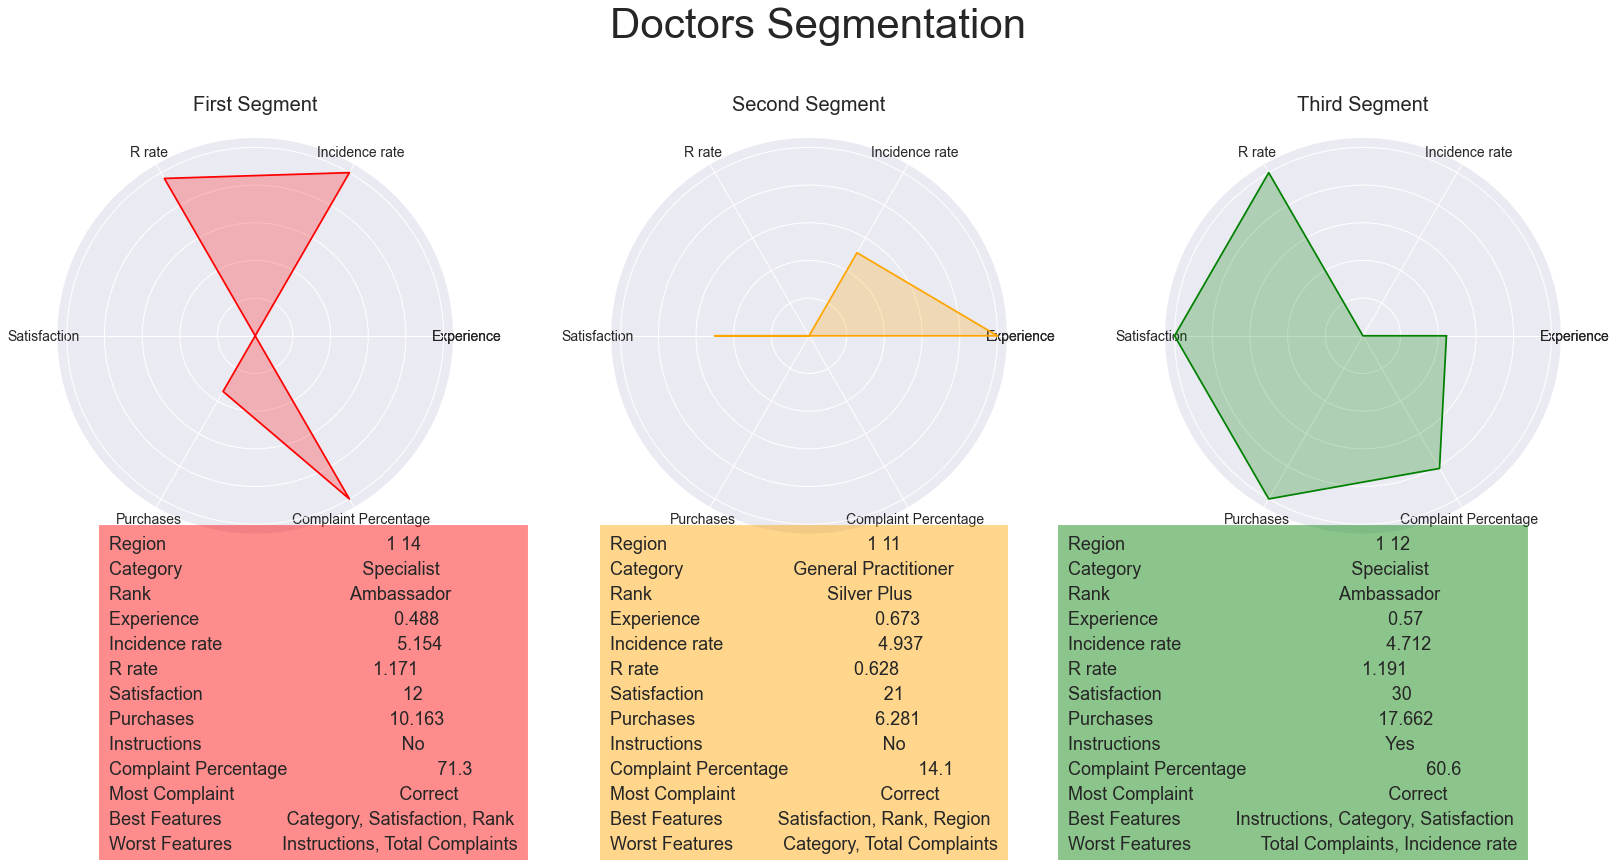

In [33]:
radar_df = categorized_data[["Experience", "Incidence rate", "R rate", "Satisfaction", "Purchases", "Complaint Percentage", "Experience"]]
radar_data = scaler.fit_transform(radar_df.values)
radar_df = pd.DataFrame(radar_data, index=radar_df.index, columns=radar_df.columns)
radar_df

angles = np.linspace(0,2*np.pi,6, endpoint=False)
angles = np.concatenate((angles,[angles[0]]))


plt.style.use('seaborn')

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize = (24,15), subplot_kw={'projection': 'polar'})
fig.suptitle("Doctors Segmentation", fontsize=42, x=0.52, y=0.78)

ax1.set_thetagrids(angles * 180/np.pi, ["Experience", "Incidence rate", "R rate", "Satisfaction","Purchases", "Complaint Percentage", "Experience"], size=14)
ax1.plot(angles, radar_df.iloc[0], color='red')
ax1.set_title("First Segment\n", size=20)
ax1.fill(angles, radar_df.iloc[0], color='red', alpha=0.25)
ax1.set_yticklabels([])

ax2.set_thetagrids(angles * 180/np.pi, ["Experience", "Incidence rate", "R rate", "Satisfaction","Purchases", "Complaint Percentage", "Experience"], size=14)
ax2.plot(angles, radar_df.iloc[1], color='orange')
ax2.set_title("Second Segment\n", size=20)
ax2.fill(angles, radar_df.iloc[1], color='orange', alpha=0.25)
ax2.set_yticklabels([])

ax3.set_thetagrids(angles * 180/np.pi , ["Experience", "Incidence rate", "R rate", "Satisfaction","Purchases", "Complaint Percentage", "Experience"], size=14)
ax3.plot(angles, radar_df.iloc[2], color='green')
ax3.set_title("Third Segment\n", size=20)
ax3.fill(angles, radar_df.iloc[2], color='green', alpha=0.25)
ax3.set_yticklabels([])

plt.figtext(0.11, 0, categorized_data.iloc[0][1:].to_string(), ha="left", fontsize=18, linespacing=1.5, bbox={"facecolor":"red", "alpha":0.45, "pad":10})

plt.figtext(0.4, 0, categorized_data.iloc[1][1:].to_string(), ha="left", fontsize=18, linespacing=1.5, bbox={"facecolor":"orange", "alpha":0.45, "pad":10})

plt.figtext(0.665, 0, categorized_data.iloc[2][1:].to_string(), ha="left", fontsize=18, linespacing=1.5, bbox={"facecolor":"green", "alpha":0.45, "pad":10})

plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.4)

plt.show()

Findings:
*Can Refer to feature contributions from challenge 4 findings!!

i) Segment 1: Conclusive Indicators = Most likely to raise complaints and most likely to have negative satisfaction scores.

ii) Segment 2: Conclusive Indicators = Least likely to make new purchases but have very good experience

iii) Segment 3: Conclusive Indicators = Most likely to have positive satisfaction scores, better experience scores, good purchase figures and least likely to raise complaints.

iv) Most of the doctors in the category of 'General Practitioners' fall in Segment 2.

Therefore, merging these segmental traits with the behavioural traits, we can assign better segment names as follows:

- Segment 1 == Complaining Customer

- Segment 2 == Customer at Risk

- Segment 3 == Most Promising Customer


The most important ways to market medical devices in general are:

- Google search engine
- Medical conferences
- Scientific literature
- Respected blogs & magazines
- Scientific awards and many more

# The New Strategy

After investing so much time into the understanding and analysing our data, we finally arrived to the most applicable part of our report. Here are the best strategies for our teams on how to approach marketing based on the insights we have.

**Step 1**

First of all we need to concentrate our efforts on the doctors we already have. As we have seen earlier, there are regions with many customers that are not buying much on avarage and the total purchase rate is also small. Since we already have information on them, it is easy to find the best products and solutions for them.

Best attention for our VIP customers. Let's start with the doctor (ID:IAEBD) who purchased 129 products last year. Our superstar! In order to make life easier for this client, we can provide a phone number of one of our sales team managers who will assist 24/7 and always help with any occuring issues. This will not only directly increase the sales to the VIP customers, but these doctors will also talk about us with their colleagues, patients and just friends. They could even mention us on a conference: that will be a big win for us.

Introductary video about us will target our newcomers so that they can learn key features of our proctucts as well as supporting survices. They are then also more likely to spread our company's name across continents.

Step 2 

As our next milestone, we should create answers to Frequently Asked Questions, manuals and videos on our website for doctors as well as patients on how to use our products. This will help them to solve some of the problems without contacting our customers support service or even getting disappointed with our products. And when they contact us, we shall take into account which cluster does the doctor belong to in order to provide fast & clear answers to their questions.

Step 3 Then we will create an easier system for submitting additional instructions so that doctors can feel free to purchase the product which will ideally fit to their patients. 

Step 4 After we have mastered previous steps, we will be able to use our clusters to precisely target our potential customers according to their behaviour for example via Google Ads.

Additionally, we should be active on orthopedical conferences, publish papers on our innovations and aim for the scientific awards so that doctors are familiar with our products. We can also use usual famous bloggers who may write reviews on our devices in order to directly target the patients.

But please note that we are all constantly confronting companies who make focus on themselves and are we getting immune to such type of ads. For that reason, we should advertise how the lifestyle of the patients will be bossted with our device rather than product itself.

Step 5 Apply our knowldge of newly identified customer segments to improve targeting

By applying all these steps thoroughly, identifying and fixing new problems down the road, we will be able to create our own legacy and save millions of lives! This is the way from Good to Great!